Reference:
https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms#the-deutsch-jozsa-algorithm

In [15]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

To implement the Deutsch-Jozsa algorithm in Qiskit, we'll start by generating a quantum circuit that implements a query operation for a randomly selected function that satisfies the promise: with 50% chance the function is constant, and with 50% change the function is balanced. For each possibility, the function is selected uniformly from the possibilities.

The argument to dj_function is the number of input bits of the function.

In [16]:
from qiskit import QuantumCircuit
import numpy as np

def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """

    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # next, choose half the possible input states
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc = add_cx(qc, f"{state:0b}")
        qc.mct(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

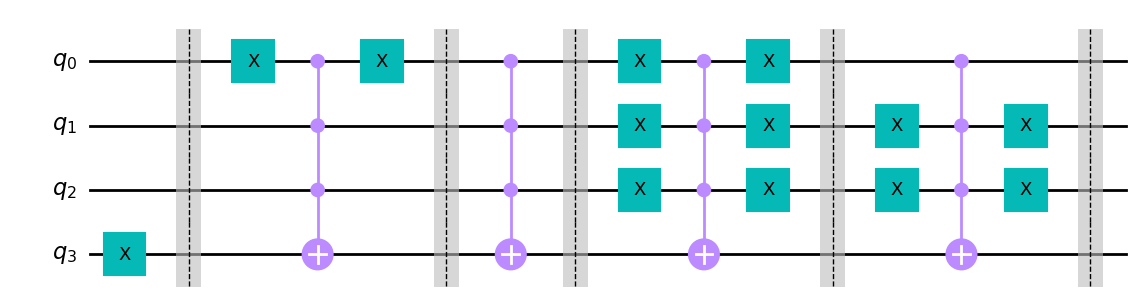

In [17]:
dj_function(3).draw()

Next we define a function that creates the Deutsch-Jozsa circuit, taking a quantum circuit implementation of a query gate as an argument.

In [18]:
def compile_circuit(function: QuantumCircuit):
    """
    Compiles a circuit for use in the Deutsch-Jozsa algorithm.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [19]:
from qiskit_aer import AerSimulator

def dj_algorithm(function: QuantumCircuit):
    """
    Determine if a Deutsch-Jozsa function is constant or balanced.
    """
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

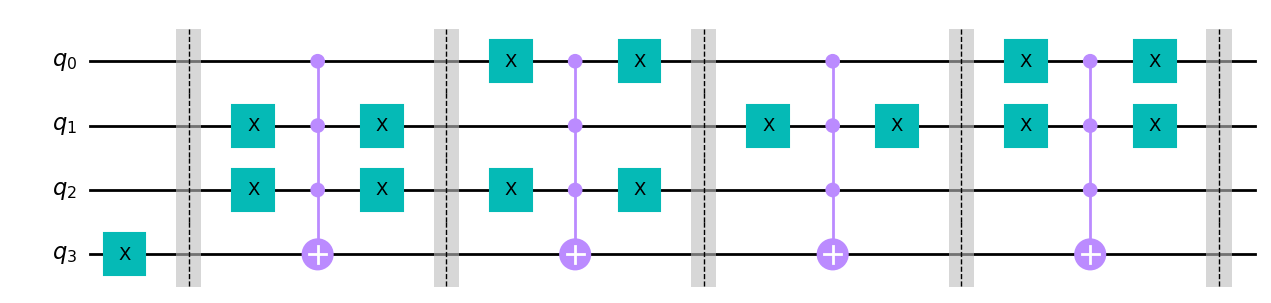

'balanced'

In [20]:
f = dj_function(3)
display(f.draw())
dj_algorithm(f)

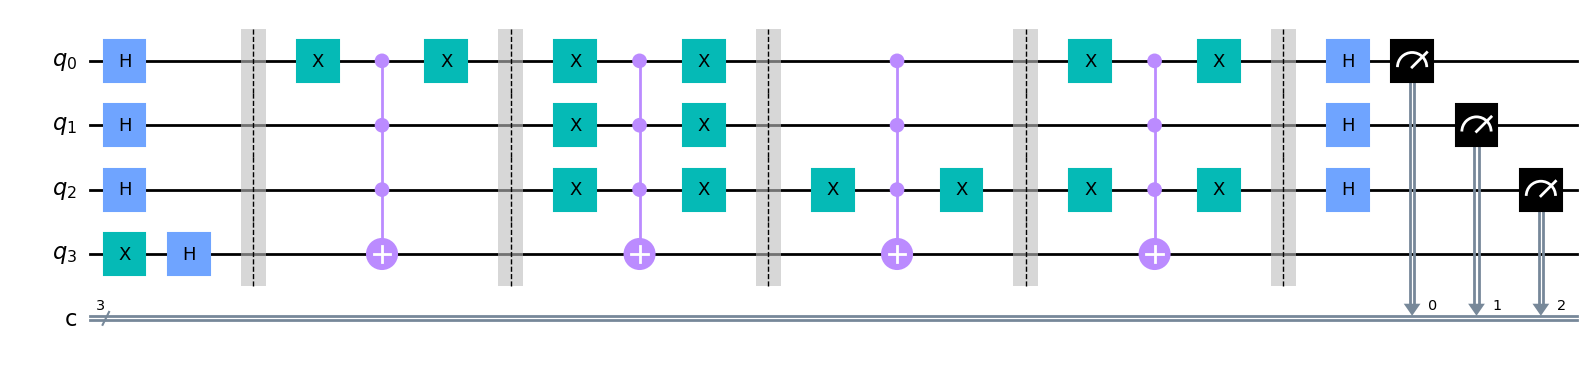

In [21]:
compile_circuit(
    dj_function(3)
).draw()

In [22]:
dj_algorithm(dj_function(3))

'balanced'

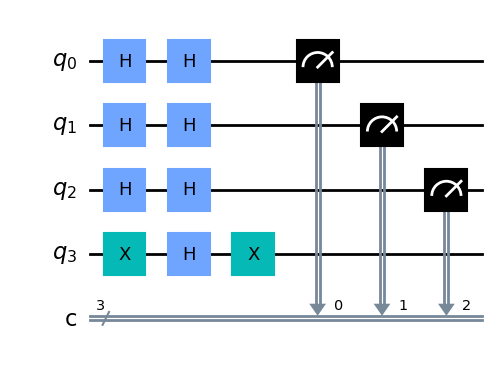

In [23]:
compile_circuit(
    #deutsch_function(2)
    dj_function(3)
).draw()